# Ultralytics YOLO based Object Detection Training Template

데이터셋을 분할합니다.

아래 코드 셀에서 FIXME 부분에 데이터셋 경로를 넣어 주세요.

데이터셋 경로에는 이미지와 label 텍스트 파일이 있는 것을 가정합니다.

Google Drive에 파일 저장

In [ ]:
# 1. Google Drive 마운트
from google.colab import drive
drive.mount('/content/drive')

# 2. Google Drive에 있는 zip 파일 경로 지정
# 예시: 내 드라이브(MyDrive) 최상위에 kim.jip 파일이 있는 경우
zip_path = "/content/drive/MyDrive/clean_dirty_basicwriter.zip"

# 3. 압축 풀 위치 (Colab의 /content 폴더에 풀기)
import zipfile, os

extract_dir = "/content/cleanm_dirtyn"
os.makedirs(extract_dir, exist_ok=True)

# 4. 압축 해제
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print("압축 해제 완료:", extract_dir)

# 5. 압축 풀린 파일 확인
import os
print(os.listdir(extract_dir))

Mounted at /content/drive
압축 해제 완료: /content/cleanm_dirtyn
['clean2_dirty1', 'clean1_dirty1', 'clean0_dirty2', 'clean2_dirty0', 'clean1_dirty1_bottles']


라벨 변환기 실행

이미지+NPY+JSON → YOLO txt

In [ ]:
import os, re, glob, json
from collections import defaultdict
import numpy as np
from PIL import Image

# =========================
# ===== 사용자 설정 ========
# =========================
BASE_DIR = "/content/cleanm_dirtyn"     # 이미지/NPY/JSON이 들어있는 상위 폴더
IMG_EXTS = {".jpg", ".jpeg", ".png", ".bmp", ".tiff", ".tif"}

# YOLO 라벨을 저장할 루트(원본 디렉토리 구조를 미러링해 .txt 저장)
LABEL_ROOT = "/content/yolo_labels"

# 원하는 클래스 순서 고정(예: clean:0, dirty:1). 비우면 자동 수집/정렬 사용.
PREFERRED_CLASSES = ["dirty_plate", "clean_plate"]

# 최소 박스 크기/면적 필터
MIN_W, MIN_H = 2, 2
MIN_AREA = 9

# 파일명에서 숫자 인덱스 추출 (예: rgb_000123.png → "000123")
INDEX_RE = re.compile(r"(\d+)(?=\.[^.]+$)")


# =========================
# ===== 유틸 함수들 ========
# =========================
def _clamp01(v: float) -> float:
    return 0.0 if v < 0.0 else (1.0 if v > 1.0 else float(v))

def to_yolo_from_xywh(x, y, w, h, W, H):
    """입력: x,y,w,h(픽셀), 출력: cx,cy,wn,hn (정규화)"""
    if W <= 0 or H <= 0 or w <= 0 or h <= 0:
        return None
    cx = (x + w/2.0) / W
    cy = (y + h/2.0) / H
    wn = w / W
    hn = h / H
    return (_clamp01(cx), _clamp01(cy), _clamp01(wn), _clamp01(hn))

def extract_index(path):
    m = INDEX_RE.search(os.path.basename(path))
    return m.group(0) if m else None

def relpath_under(root, path):
    """root 기준으로 path의 디렉토리 상대경로를 반환"""
    return os.path.relpath(os.path.dirname(path), start=root)

def ensure_dir(p):
    os.makedirs(p, exist_ok=True)

def clamp_box(x1, y1, x2, y2, W, H):
    x1 = max(0, min(int(x1), W-1))
    y1 = max(0, min(int(y1), H-1))
    x2 = max(0, min(int(x2), W-1))
    y2 = max(0, min(int(y2), H-1))
    return x1, y1, x2, y2

def valid_box(x1, y1, x2, y2):
    w, h = x2 - x1, y2 - y1
    if w < MIN_W or h < MIN_H: return False
    if w * h < MIN_AREA: return False
    return True


# ===============================
# ===== 라벨 JSON 파서 ===========
# ===============================
def parse_labels_json(json_path):
    """
    라벨 JSON을 semanticId(int) -> class_name(str) 매핑으로 파싱
    지원 포맷:
      A) {"0":{"class":"dirty_plate"}, "1":{"class":"clean_plate"}}
      B) {"labels": ["clean", "dirty", ...]}  또는 dict item에 {"class": "..."} 포함
      C) ["clean","dirty",...]  또는 [{"class":...}, ...]
    """
    with open(json_path, "r", encoding="utf-8") as f:
        data = json.load(f)

    # A 타입
    if isinstance(data, dict) and all(isinstance(v, dict) and "class" in v for v in data.values()):
        return {int(k): v["class"] for k, v in data.items()}

    # B 타입
    if isinstance(data, dict) and "labels" in data and isinstance(data["labels"], list):
        def _name(item):
            if isinstance(item, str): return item
            if isinstance(item, dict): return item.get("class") or item.get("label")
            return None
        return {i: _name(item) for i, item in enumerate(data["labels"])}

    # C/D 타입
    if isinstance(data, list) and (len(data) == 0 or isinstance(data[0], (str, dict))):
        def _name(x):
            if isinstance(x, str): return x
            if isinstance(x, dict): return x.get("class") or x.get("label")
            return None
        return {i: _name(x) for i, x in enumerate(data)}

    raise ValueError(f"Unrecognized label json format: {json_path}")


# =======================================
# ===== (img, npy, json) 세트 매칭 =======
# =======================================
def collect_pairs(dir_path):
    """
    dir_path 아래를 재귀로 내려가며 (이미지, bbox_npy, labels_json) 세트를
    '파일명 끝 숫자 인덱스'로 매칭한다.
    반환: good(완전 세트), missing(불완전 세트)
    """
    pairs = defaultdict(dict)

    # 1) 이미지: 재귀 탐색
    for p in glob.glob(os.path.join(dir_path, "**", "*"), recursive=True):
        if os.path.splitext(p)[1].lower() in IMG_EXTS:
            idx = extract_index(p)
            if idx and "img" not in pairs[idx]:
                pairs[idx]["img"] = p

    # 2) 바운딩박스 npy: 대표/대안 패턴
    npy_patterns = [
        os.path.join(dir_path, "**", "bounding_box_2d_tight_*.npy"),
        os.path.join(dir_path, "**", "*bounding*box*2d*tight*.npy"),
    ]
    for pat in npy_patterns:
        for p in glob.glob(pat, recursive=True):
            idx = extract_index(p)
            if idx and "npy" not in pairs[idx]:
                pairs[idx]["npy"] = p

    # 3) 라벨 json: 대표/대안 패턴
    json_patterns = [
        os.path.join(dir_path, "**", "bounding_box_2d_tight_labels_*.json"),
        os.path.join(dir_path, "**", "*labels*.json"),
    ]
    for pat in json_patterns:
        for p in glob.glob(pat, recursive=True):
            idx = extract_index(p)
            if idx and "json" not in pairs[idx]:
                pairs[idx]["json"] = p

    good = {k: v for k, v in pairs.items() if {"img", "npy", "json"} <= v.keys()}
    missing = {k: v for k, v in pairs.items() if k not in good}

    imgs = sum(1 for v in pairs.values() if "img" in v)
    npys = sum(1 for v in pairs.values() if "npy" in v)
    jsons = sum(1 for v in pairs.values() if "json" in v)
    print(f"[DBG] {dir_path} scan → img:{imgs}, npy:{npys}, json:{jsons}, full:{len(good)}, miss:{len(missing)}")
    return good, missing


# ===================================
# ===== 1st pass: 클래스 수집 =========
# ===================================
def collect_classes_only(dir_path, class_vocab):
    pairs, missing = collect_pairs(dir_path)
    if missing:
        print(f"[WARN] {dir_path} 불완전 세트 {len(missing)}개 (건너뜀)")

    skipped = 0
    for idx, paths in sorted(pairs.items(), key=lambda kv: int(kv[0])):
        try:
            labels_map = parse_labels_json(paths["json"])
            for cname in labels_map.values():
                if cname is not None:
                    class_vocab.add(cname)
        except Exception as e:
            print(f"[SKIP] {idx} 라벨 파싱 예외: {e}")
            skipped += 1
    return len(pairs), skipped, pairs


# ===================================
# ===== NPY 로더(견고형) ==============
# ===================================
def load_bboxes_any(npy_path):
    """
    반환: 리스트[(semanticId(int), x1, y1, x2, y2)]
    지원:
      - 구조화 배열: fields 포함 (semanticId, x_min, y_min, x_max, y_max)
      - 일반 배열: (N,5) -> (cls, x1, y1, x2, y2)
      - 일반 배열: (N,4) -> (x1, y1, x2, y2) (cls=0으로 둠; JSON 매핑으로 해석)
    """
    arr = np.load(npy_path, allow_pickle=True)

    out = []
    # 구조화 배열
    if getattr(arr, "dtype", None) is not None and arr.dtype.names:
        names = set(arr.dtype.names)
        field_map = {
            "semanticId": next((n for n in names if "semantic" in n.lower() and "id" in n.lower()), None),
            "x_min":      next((n for n in names if n.lower() in ("x_min","xmin")), None),
            "y_min":      next((n for n in names if n.lower() in ("y_min","ymin")), None),
            "x_max":      next((n for n in names if n.lower() in ("x_max","xmax")), None),
            "y_max":      next((n for n in names if n.lower() in ("y_max","ymax")), None),
        }
        if not all(field_map.values()):
            raise ValueError(f"필드 부족: {arr.dtype.names}")
        for r in arr:
            sid = int(r[field_map["semanticId"]])
            x1 = float(r[field_map["x_min"]]); y1 = float(r[field_map["y_min"]])
            x2 = float(r[field_map["x_max"]]); y2 = float(r[field_map["y_max"]])
            out.append((sid, x1, y1, x2, y2))
        return out

    # 일반 배열
    a = np.asarray(arr)
    if a.ndim == 2 and a.shape[1] in (4,5):
        if a.shape[1] == 5:
            for row in a:
                sid, x1, y1, x2, y2 = row.tolist()
                out.append((int(sid), float(x1), float(y1), float(x2), float(y2)))
        else:
            for row in a:
                x1, y1, x2, y2 = row.tolist()
                out.append((0, float(x1), float(y1), float(x2), float(y2)))
        return out

    raise ValueError(f"지원하지 않는 배열 차원/형상: {getattr(a,'shape',type(a))}")


# =========================================
# ===== 2nd pass: YOLO txt 생성 =============
# =========================================
def write_labels_with_mapping(pairs, class2id):
    made_txt = empty_txt = skipped = 0

    for idx, paths in sorted(pairs.items(), key=lambda kv: int(kv[0])):
        img_path  = paths["img"]
        npy_path  = paths["npy"]
        json_path = paths["json"]

        try:
            # 이미지 크기
            with Image.open(img_path) as im:
                W, H = im.size

            # 바운딩박스 로드
            raw_boxes = load_bboxes_any(npy_path)

            # semanticId → 클래스 이름
            labels_map = parse_labels_json(json_path)

            lines = []
            for sid, x1, y1, x2, y2 in raw_boxes:
                lb = labels_map.get(int(sid))
                if lb is None or lb not in class2id:
                    continue
                yid = class2id[lb]

                # 박스 클램프/검증
                x1, y1, x2, y2 = clamp_box(x1, y1, x2, y2, W, H)
                if x2 <= x1 or y2 <= y1:
                    continue
                if not valid_box(x1, y1, x2, y2):
                    continue

                w, h = x2 - x1, y2 - y1
                yolo = to_yolo_from_xywh(x1, y1, w, h, W, H)
                if yolo is None:
                    continue
                cx, cy, wn, hn = yolo
                lines.append(f"{yid} {cx:.6f} {cy:.6f} {wn:.6f} {hn:.6f}")

            # 저장 경로: LABEL_ROOT/BASE_DIR상대경로/파일명.txt
            rel_dir = relpath_under(BASE_DIR, img_path)  # img_path가 BASE_DIR 하위라는 가정
            save_dir = os.path.join(LABEL_ROOT, rel_dir)
            ensure_dir(save_dir)
            base = os.path.splitext(os.path.basename(img_path))[0]
            label_path = os.path.join(save_dir, base + ".txt")

            with open(label_path, "w", encoding="utf-8") as w:
                w.write("\n".join(lines))

            if lines: made_txt += 1
            else:     empty_txt += 1

        except Exception as e:
            print(f"[SKIP] {idx} 예외: {e}")
            skipped += 1
            continue

    return made_txt, empty_txt, skipped


# ======================
# ===== 드라이버 =========
# ======================
def convert_all(base_dir):
    """
    base_dir 아래의 하위 폴더들을 탐색하고,
    없다면 base_dir 자체를 처리 대상으로 사용
    """
    subdirs = sorted(d for d in glob.glob(os.path.join(base_dir, "*")) if os.path.isdir(d))
    if not subdirs:
        subdirs = [base_dir]

    # 1) 클래스 수집
    class_vocab = set()
    folder_pairs = []
    total_skipped_collect = 0

    for d in subdirs:
        m, s, pairs = collect_classes_only(d, class_vocab)
        print(f"[INFO] {d} -> 매칭 세트 {m}개, 수집 스킵 {s}개")
        folder_pairs.append((d, pairs))
        total_skipped_collect += s

    # 2) 클래스 고정 및 매핑
    if PREFERRED_CLASSES:
        classes_sorted = list(PREFERRED_CLASSES)
    else:
        classes_sorted = sorted(c for c in class_vocab if c is not None)

    class2id = {c:i for i, c in enumerate(classes_sorted)}
    print("[INFO] Classes (고정):")
    for c in classes_sorted:
        print(f"  {class2id[c]} -> {c}")

    # classes.txt 저장(라벨 루트에도 남기면 편함)
    ensure_dir(LABEL_ROOT)
    classes_txt = os.path.join(LABEL_ROOT, "classes.txt")
    with open(classes_txt, "w", encoding="utf-8") as f:
        f.write("\n".join(classes_sorted))
    print(f"[INFO] classes.txt 저장: {classes_txt}")

    # 3) YOLO 라벨 txt 생성
    total_made = total_empty = total_skipped_write = 0
    for dir_path, pairs in folder_pairs:
        m, e, s = write_labels_with_mapping(pairs, class2id)
        total_made  += m
        total_empty += e
        total_skipped_write += s
        print(f"[INFO] {dir_path} -> 라벨 있는 TXT {m}개, 빈 TXT {e}개, 스킵 {s}개")

    # 최종 리포트
    print("\n" + "="*70)
    print(f"[DONE] 수집 단계 스킵: {total_skipped_collect}개")
    print(f"[TOTAL] 라벨 있는 TXT: {total_made}개, 빈 TXT: {total_empty}개, 스킵: {total_skipped_write}개")


if __name__ == "__main__":
    convert_all(BASE_DIR)


[DBG] /content/cleanm_dirtyn/clean0_dirty2 scan → img:1000, npy:1000, json:1000, full:1000, miss:0
[INFO] /content/cleanm_dirtyn/clean0_dirty2 -> 매칭 세트 1000개, 수집 스킵 0개
[DBG] /content/cleanm_dirtyn/clean1_dirty1 scan → img:1000, npy:1000, json:1000, full:1000, miss:0
[INFO] /content/cleanm_dirtyn/clean1_dirty1 -> 매칭 세트 1000개, 수집 스킵 0개
[DBG] /content/cleanm_dirtyn/clean1_dirty1_bottles scan → img:1300, npy:1300, json:1300, full:1300, miss:0
[INFO] /content/cleanm_dirtyn/clean1_dirty1_bottles -> 매칭 세트 1300개, 수집 스킵 0개
[DBG] /content/cleanm_dirtyn/clean2_dirty0 scan → img:1000, npy:1000, json:1000, full:1000, miss:0
[INFO] /content/cleanm_dirtyn/clean2_dirty0 -> 매칭 세트 1000개, 수집 스킵 0개
[DBG] /content/cleanm_dirtyn/clean2_dirty1 scan → img:847, npy:847, json:847, full:847, miss:0
[INFO] /content/cleanm_dirtyn/clean2_dirty1 -> 매칭 세트 847개, 수집 스킵 0개
[INFO] Classes (고정):
  0 -> dirty_plate
  1 -> clean_plate
[INFO] classes.txt 저장: /content/yolo_labels/classes.txt
[INFO] /content/cleanm_dirtyn/clea

YOLO 데이터셋 구성

이 코드는 원본 이미지·라벨을 모아서 YOLO 학습에 맞는 디렉토리 구조로 정리하고, 70:30 비율로 학습/검증 데이터셋을 자동으로 분리해준다.

In [ ]:
import os, glob, shutil, random, re

# ===== 사용자 설정 =====
IMAGE_ROOT = "/content/cleanm_dirtyn"   # 원본 이미지 루트
LABEL_ROOT = "/content/yolo_labels"     # 라벨(txt) 루트 (앞 단계에서 생성됨)
OUT_ROOT   = "/content/yolo_dataset"    # YOLO 학습용 출력 루트
TRAIN_RATIO = 0.7
IMG_EXTS = {".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff"}
RND_SEED = 42
random.seed(RND_SEED)

# 클래스 이름: JSON 기준 (앞 단계 고정값과 일치시킴)
CLASSES = ["dirty_plate", "clean_plate"]

# ---------- 유틸 ----------
def is_image(p):
    return os.path.splitext(p)[1].lower() in IMG_EXTS

def has_number_basename(p):
    base = os.path.splitext(os.path.basename(p))[0]
    return re.search(r"\d+", base) is not None

def relbase(path, root):
    """root 기준 상대경로에서 확장자 제거 (하위 폴더 구조 보존용 키)"""
    rel = os.path.relpath(path, root)
    return os.path.splitext(rel)[0].replace("\\", "/")

def under_subdir(path, root):
    """root 바로 아래가 아닌 하위 디렉토리에 있는 파일만 True"""
    rel = os.path.relpath(path, root)
    return os.sep in rel

def safe_copy(src, dst):
    os.makedirs(os.path.dirname(dst), exist_ok=True)
    shutil.copy2(src, dst)

# ---------- 1) 재귀 스캔 (이미지/라벨 분리 루트) ----------
images = [p for p in glob.glob(os.path.join(IMAGE_ROOT, "**", "*"), recursive=True)
          if os.path.isfile(p) and is_image(p) and under_subdir(p, IMAGE_ROOT)]

labels = [p for p in glob.glob(os.path.join(LABEL_ROOT, "**", "*.txt"), recursive=True)
          if os.path.isfile(p) and os.path.basename(p) != "classes.txt" and has_number_basename(p) and under_subdir(p, LABEL_ROOT)]

print(f"[INFO] images found under {IMAGE_ROOT}: {len(images)}")
print(f"[INFO] labels found under {LABEL_ROOT}: {len(labels)}")

# ---------- 2) 이미지-라벨 매칭 (각 루트의 상대경로 기반) ----------
img_bases = {relbase(p, IMAGE_ROOT): p for p in images}
lbl_bases = {relbase(p, LABEL_ROOT): p for p in labels}

common_keys = sorted(set(img_bases.keys()) & set(lbl_bases.keys()))
pairs = [(img_bases[k], lbl_bases[k]) for k in common_keys]

missing_labels = sorted(set(img_bases.keys()) - set(lbl_bases.keys()))
orphan_labels  = sorted(set(lbl_bases.keys()) - set(img_bases.keys()))

print(f"[INFO] paired: {len(pairs)}")
if missing_labels:
    print(f"[WARN] images without labels: {len(missing_labels)} (ex: {missing_labels[:5]})")
if orphan_labels:
    print(f"[WARN] labels without images: {len(orphan_labels)} (ex: {orphan_labels[:5]})")

# ---------- 3) 무작위 분할 ----------
random.shuffle(pairs)
n_total = len(pairs)
n_train = int(n_total * TRAIN_RATIO)
train_pairs = pairs[:n_train]
val_pairs   = pairs[n_train:]
print(f"[SPLIT] train: {len(train_pairs)}, val: {len(val_pairs)} (ratio={TRAIN_RATIO:.2f})")

# ---------- 4) 출력 폴더로 복사 (원본의 하위 구조를 보존) ----------
def dst_path_for(src_path, split, kind, root):
    # kind: "images" or "labels"
    # root: IMAGE_ROOT 또는 LABEL_ROOT (각 소스 루트)
    rel = os.path.relpath(src_path, root)
    return os.path.join(OUT_ROOT, kind, split, rel)

def copy_pairs(pairs, split):
    for img_src, lbl_src in pairs:
        img_dst = dst_path_for(img_src, split, "images", IMAGE_ROOT)
        lbl_dst = dst_path_for(lbl_src, split, "labels", LABEL_ROOT)
        safe_copy(img_src, img_dst)
        safe_copy(lbl_src, lbl_dst)

copy_pairs(train_pairs, "train")
copy_pairs(val_pairs, "val")

# ---------- 5) 최종 결과 ----------
def count_files(root, pattern):
    return sum(1 for p in glob.glob(os.path.join(root, pattern), recursive=True) if os.path.isfile(p))

print("[DONE] split & copy completed.")
print(" train images:", count_files(os.path.join(OUT_ROOT, "images", "train"), "**/*"))
print(" train labels:", count_files(os.path.join(OUT_ROOT, "labels", "train"), "**/*.txt"))
print(" val images  :", count_files(os.path.join(OUT_ROOT, "images", "val"), "**/*"))
print(" val labels  :", count_files(os.path.join(OUT_ROOT, "labels", "val"), "**/*.txt"))

# ---------- 6) data.yaml 생성 ----------
yaml_path = os.path.join(OUT_ROOT, "PROJECT_CUSTOM_DATASET.yaml")
yaml = f"""# YOLO dataset config
path: {OUT_ROOT}
train: images/train
val: images/val
nc: {len(CLASSES)}
names:
""" + "\n".join(f"  - {c}" for c in CLASSES) + "\n"

with open(yaml_path, "w", encoding="utf-8") as f:
    f.write(yaml)

print("[WRITE] PROJECT_CUSTOM_DATASET.yaml saved:", yaml_path)
print("\n[HINT] Ultralytics 학습 예시:")
print(" from ultralytics import YOLO")
print(f" model = YOLO('yolov8s.pt')")
print(f" model.train(data='{yaml_path}', epochs=100, imgsz=640, batch=16, device=0, workers=2, project='runs/train', name='custom_yolo')")


[INFO] images found under /content/cleanm_dirtyn: 5147
[INFO] labels found under /content/yolo_labels: 5147
[INFO] paired: 5147
[SPLIT] train: 3602, val: 1545 (ratio=0.70)
[DONE] split & copy completed.
 train images: 3602
 train labels: 3602
 val images  : 1545
 val labels  : 1545
[WRITE] PROJECT_CUSTOM_DATASET.yaml saved: /content/yolo_dataset/PROJECT_CUSTOM_DATASET.yaml

[HINT] Ultralytics 학습 예시:
 from ultralytics import YOLO
 model = YOLO('yolov8s.pt')
 model.train(data='/content/yolo_dataset/PROJECT_CUSTOM_DATASET.yaml', epochs=100, imgsz=640, batch=16, device=0, workers=2, project='runs/train', name='custom_yolo')


데이터셋 구성 파일을 생성합니다.

프로젝트 내용에 맞게 수정해줍니다.

names 부분만 수정합니다.

In [ ]:
import os

# YOLO 데이터셋 최상위 경로
DATASET_ROOT_PATH = "/content/yolo_dataset"

# data.yaml 내용 작성 (순서 반드시 NAMES 고정된 것과 동일하게!)
text_lines = f"""# YOLO dataset config
path: {DATASET_ROOT_PATH}   # dataset root dir

train: images/train         # train images
val: images/val             # val images

nc: 2                       # 클래스 개수
names:
  - dirty_plate
  - clean_plate
"""

# yaml 파일 저장
yaml_path = os.path.join(DATASET_ROOT_PATH, "PROJECT_CUSTOM_DATASET.yaml")
with open(yaml_path, 'w') as f:
    f.write(text_lines)

print("✅ data.yaml 생성 완료:", yaml_path)


✅ data.yaml 생성 완료: /content/yolo_dataset/PROJECT_CUSTOM_DATASET.yaml


ultralytics에서 YOLO 모델을 훈련합니다.

[훈련 설정 문서 링크](https://docs.ultralytics.com/ko/modes/train/#why-choose-ultralytics-yolo-for-training)를 참고하여 아래 None을 수정한 후 적당한 모델을 훈련합니다.

Data augmentation을 적용하고자 하는 경우, 아래 [데이터 증강 문서 링크](https://docs.ultralytics.com/ko/guides/yolo-data-augmentation/#example-configurations)를 참고합니다.


In [ ]:
!pip install ultralytics


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 24.6 MB/s eta 0:00:00


YOLO 모델 학습

In [ ]:
from ultralytics import YOLO
import torch, os, math

# =========================
# 기본 설정
# =========================
BASE_YOLO_MODEL = "yolov8s.pt"         # 사전학습 가중치
DATA_YAML       = "/content/yolo_dataset/PROJECT_CUSTOM_DATASET.yaml"  # <-- names 순서: [dirty_plate, clean_plate]
PROJECT_DIR     = "runs/train"
MODEL_NAME      = "custom_yolo"

# 학습 하이퍼파라미터
NUM_EPOCHS   = 100
IMAGE_SIZE   = 640
BATCH_SIZE   = 16
PATIENCE     = 10

# =========================
# 안전 장치 / 품질 옵션
# =========================
# 1) 디바이스 자동 선택 (GPU 없으면 CPU로 폴백)
DEVICE = "0" if torch.cuda.is_available() else "cpu"

# 2) 워커 수 설정 (Colab/서버 상황에 맞춰)
CPU_COUNT = os.cpu_count() or 2
WORKERS   = max(2, min(8, CPU_COUNT // 2))  # 과도하게 크지 않게

# 3) 재현성
SEED = 42

# 4) 체크포인트/로그 옵션
SAVE_PERIOD = 5      # 5 epoch마다 가중치 저장
VERBOSE     = True
PLOTS       = True   # 학습 곡선/PR커브 등 저장

# 5) 최후반 모자이크 끄기(수렴 안정)
CLOSE_MOSAIC_LAST = 10  # 마지막 10epoch 모자이크 off

# 6) 최적화기/러닝레이트(필요 시 조정)
OPTIMIZER = "auto"   # ['auto','SGD','Adam','AdamW'] 등
LR0      = 0.01      # 초기 lr (기본은 모델/배치에 따라 달라질 수 있음)
LRF      = 0.01      # 최종 lr 비율

# =========================
# 모델 로드 & 학습
# =========================
model = YOLO(BASE_YOLO_MODEL)

train_results = model.train(
    data=DATA_YAML,
    epochs=NUM_EPOCHS,
    imgsz=IMAGE_SIZE,
    batch=BATCH_SIZE,
    device=DEVICE,
    workers=WORKERS,
    project=PROJECT_DIR,
    name=MODEL_NAME,
    patience=PATIENCE,
    cache=True,                 # 첫 epoch 이후 속도 ↑ (메모리 여유 필요)
    seed=SEED,
    save_period=SAVE_PERIOD,
    verbose=VERBOSE,
    plots=PLOTS,
    cos_lr=True,                # cosine 스케줄
    close_mosaic=CLOSE_MOSAIC_LAST,
    optimizer=OPTIMIZER,
    lr0=LR0,
    lrf=LRF,
    amp=True,                   # 자동 혼합정밀
    exist_ok=True,              # 동일 이름 덮어쓰기 허용

    # ==== [과적합 억제 옵션] ====
    weight_decay=5e-4,        # L2 규제 강화(기본보다 약간↑)
    label_smoothing=0.05,     # 라벨 스무딩(과도한 확신 완화)
    mixup=0.15,               # MixUp으로 데이터 다양화

    # (선택) 약한 증강 파라미터 예시 — 과하면 ROI-분류기와 분포가 달라질 수 있어 주의
    degrees=5.0, translate=0.05, scale=0.1, shear=2.0, perspective=0.0,
    hsv_h=0.01, hsv_s=0.7, hsv_v=0.4,

)

print("✅ Train done. Best weights:", model.ckpt_path if hasattr(model, 'ckpt_path') else "runs/train/.../best.pt")


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
WARNING ⚠️ 'label_smoothing' is deprecated and will be removed in in the future.
Ultralytics 8.3.187 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=True, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=/content/yolo_dataset/PROJECT_CUSTOM_DATASET.yaml, degrees=5.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half

Train / Validation 최종 Loss 가져오기

In [ ]:
import pandas as pd

results_csv = "/content/runs/train/custom_yolo/results.csv"
df = pd.read_csv(results_csv)

# 마지막 epoch 값 가져오기
final_train_loss = df["train/box_loss"].iloc[-1] + df["train/cls_loss"].iloc[-1] + df["train/dfl_loss"].iloc[-1]
final_val_loss   = df["val/box_loss"].iloc[-1]   + df["val/cls_loss"].iloc[-1]   + df["val/dfl_loss"].iloc[-1]

print("Final Train Loss:", final_train_loss)
print("Final Val Loss:", final_val_loss)


Final Train Loss: 0.9511700000000001
Final Val Loss: 0.93466


Confusion Matrix 그리기

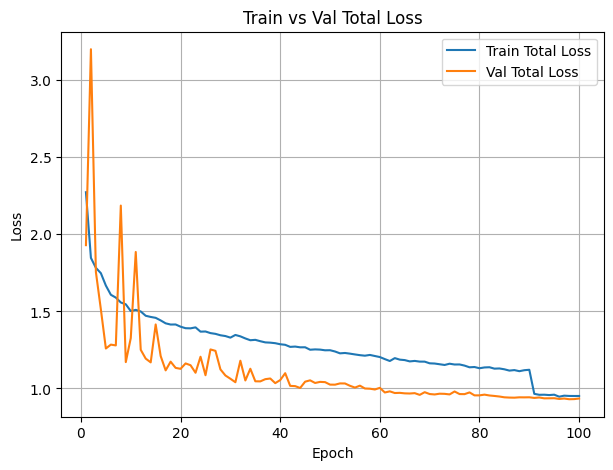

Ultralytics 8.3.187 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 11,126,358 parameters, 0 gradients, 28.4 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3561.7±954.2 MB/s, size: 528.9 KB)
val: Scanning /content/yolo_dataset/labels/val/clean0_dirty2.cache... 1545 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 1545/1545 2382426.4it/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 97/97 1.7it/s 56.6s
                   all       1545       3344      0.998      0.994      0.995      0.993
           dirty_plate       1257       1565      0.998      0.996      0.995      0.994
           clean_plate       1237       1779      0.997      0.992      0.995      0.993
Speed: 0.5ms preprocess, 9.2ms inference, 0.0ms loss, 1.7ms postprocess per image
Saving runs/detect/val4/predictions.json...
Results saved to runs/detect/val4
Validation results saved in: runs/detec

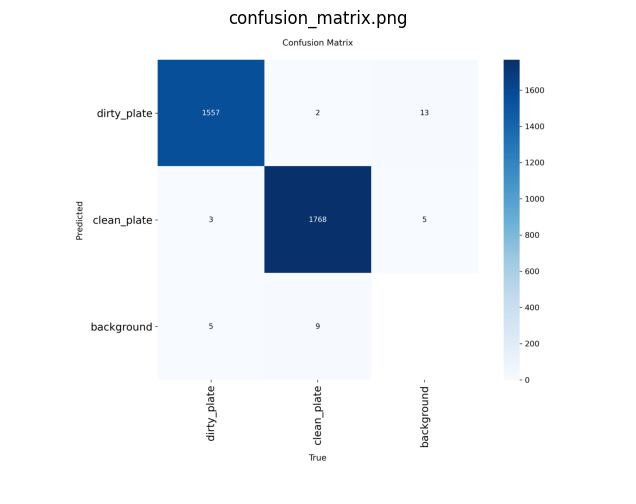

⚠️ Not found: runs/detect/val4/F1_curve.png
⚠️ Not found: runs/detect/val4/PR_curve.png
⚠️ Not found: runs/detect/val4/labels_correlogram.png


In [ ]:
# =========================
# 0) 준비
# =========================
import os, glob, cv2
import pandas as pd
import matplotlib.pyplot as plt
from ultralytics import YOLO

# 경로 설정 (필요시 수정)
RESULTS_CSV = "/content/runs/train/custom_yolo/results.csv"
BEST_PT     = "/content/runs/train/custom_yolo/weights/best.pt"
DATA_YAML   = "/content/yolo_dataset/PROJECT_CUSTOM_DATASET.yaml"

# =========================
# 1) results.csv → Train/Val Loss 곡선
# =========================
df = pd.read_csv(RESULTS_CSV)

# YOLO 버전에 따라 존재할 수 있는 손실 컬럼 후보 (있는 것만 사용)
train_loss_cols = [c for c in [
    "train/box_loss","train/cls_loss","train/dfl_loss",
    "train/pose_loss","train/seg_loss","train/obj_loss"
] if c in df.columns]

val_loss_cols = [c for c in [
    "val/box_loss","val/cls_loss","val/dfl_loss",
    "val/pose_loss","val/seg_loss","val/obj_loss"
] if c in df.columns]

if not train_loss_cols or not val_loss_cols:
    print("⚠️ results.csv에서 손실 컬럼을 찾지 못했습니다. df.columns로 확인해보세요:")
    print(df.columns.tolist())

# 총 손실 (있는 컬럼만 합산)
df["train/total_loss"] = df[train_loss_cols].sum(axis=1) if train_loss_cols else None
df["val/total_loss"]   = df[val_loss_cols].sum(axis=1)   if val_loss_cols   else None

# 에폭 축 (results.csv에 'epoch'가 있으면 사용, 없으면 0..N-1)
epochs = df["epoch"] if "epoch" in df.columns else range(len(df))

# --- Train vs Val Total Loss ---
plt.figure(figsize=(7,5))
if "train/total_loss" in df.columns:
    plt.plot(epochs, df["train/total_loss"], label="Train Total Loss")
if "val/total_loss" in df.columns:
    plt.plot(epochs, df["val/total_loss"], label="Val Total Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train vs Val Total Loss")
plt.legend()
plt.grid(True)
plt.show()

# (선택) 세부 손실 곡선도 보고 싶다면 주석 해제
# for col in train_loss_cols:
#     plt.figure(figsize=(7,4))
#     plt.plot(epochs, df[col])
#     plt.xlabel("Epoch"); plt.ylabel(col); plt.title(col); plt.grid(True); plt.show()
# for col in val_loss_cols:
#     plt.figure(figsize=(7,4))
#     plt.plot(epochs, df[col])
#     plt.xlabel("Epoch"); plt.ylabel(col); plt.title(col); plt.grid(True); plt.show()

# =========================
# 2) Validation 실행 + 주요 그래프 화면에 표시(show)
# =========================
model = YOLO(BEST_PT)
metrics = model.val(
    data=DATA_YAML,
    split="val",
    conf=0.25,
    iou=0.6,
    plots=True,      # 저장
    save_json=True
)
val_dir = metrics.save_dir  # 보통 runs/val/expN
print("Validation results saved in:", val_dir)

# 표시할 파일 목록
plot_files = [
    "confusion_matrix.png",
    "F1_curve.png",
    "PR_curve.png",
    "labels_correlogram.png"
]

def show_img(path, title=None, size=(8,6)):
    if not os.path.exists(path):
        print(f"⚠️ Not found: {path}")
        return
    img = cv2.imread(path)
    if img is None:
        print(f"⚠️ Failed to read: {path}")
        return
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=size)
    plt.imshow(img)
    plt.axis("off")
    if title: plt.title(title)
    plt.show()

# 저장된 이미지들 show
for fname in plot_files:
    show_img(os.path.join(val_dir, fname), title=fname)

# 참고: 가장 최근 val 폴더에서 찾고 싶을 때(이미 val을 해둔 상태라면)
# latest_val = sorted(glob.glob("runs/val/*"), key=os.path.getmtime)[-1]
# for fname in plot_files:
#     show_img(os.path.join(latest_val, fname), title=fname)
